In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
calc_temps('2017-02-28', '2017-03-28')

[(62.0, 72.0965909090909, 82.0)]

In [10]:
temperature = calc_temps('2017-02-28', '2017-03-28')
mean_temp = temperature[0][1]
avg_temp = pd.DataFrame({'Temperature':[mean_temp]})
avg_temp

,Temperature
0,72.096591


In [11]:
lower_temp = temperature[0][0]
upper_temp = temperature[0][2]
limits =  (upper_temp - lower_temp)/2
limits

10.0

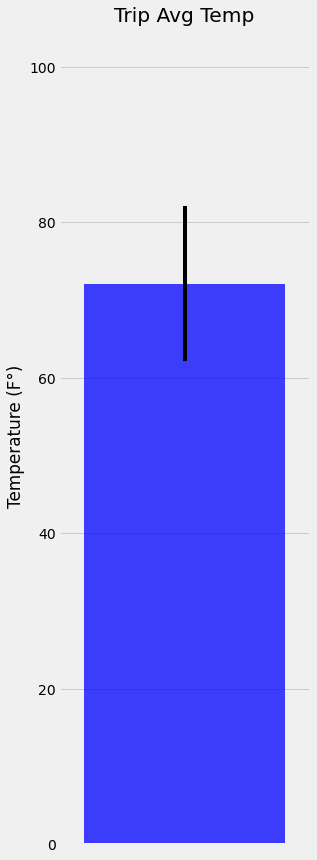

In [12]:
plt.figure(figsize=(4,14))
x_axis = np.arange(len(avg_temp)) + 0.5
tick_locations = [value for value in x_axis]
plt.bar(x_axis, avg_temp["Temperature"],color='b', alpha=0.75,yerr=limits)
plt.errorbar(x_axis, mean_temp )
plt.xticks(x_axis-0.5)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F°)")
plt.xlim(0,1)
plt.ylim(0,105)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.savefig("Bonus_Outputs/Trip_Avg_Temp.png")
plt.show()

### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.date, Measurement.station,Measurement.prcp).all()
rainfall_df = pd.DataFrame(rainfall, columns=['Date', 'Stations','Precipitation'])
rainfall_df = rainfall_df.dropna(how="any")
rainfall_per_station = rainfall_df.groupby('Stations')
rainfall_per_station = rainfall_per_station.mean()
rainfall_per_station =  rainfall_per_station.sort_values(by='Precipitation', ascending = False)
rainfall_per_station

,Precipitation
Stations,
USC00516128,0.429988
USC00519281,0.212352
USC00518838,0.207222
USC00513117,0.141921
USC00514830,0.121058
USC00519523,0.114961
USC00517948,0.063602
USC00519397,0.049020
USC00511918,0.047971


In [14]:
rainfall_stations = session.query(Station.station ,Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_titles = pd.DataFrame(rainfall_stations , columns=['Stations','Name','Latitude','Longitude','Elevation'])
rainfall_merge = pd.merge(rainfall_per_station,station_titles, on ="Stations", how="inner")
rainfall_merge

,Stations,Precipitation,Name,Latitude,Longitude,Elevation
0,USC00516128,0.429988,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,0.212352,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00518838,0.207222,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
3,USC00513117,0.141921,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00514830,0.121058,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519523,0.114961,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00517948,0.063602,"PEARL CITY, HI US",21.39340,-157.97510,11.9
7,USC00519397,0.049020,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
8,USC00511918,0.047971,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9


In [15]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("08-01")

[(67.0, 75.54, 83.0)]

In [16]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
counter = 0
d_normals = []
date_list = []
minimum = []
average = []
maximum = []

# Set the start and end date of the trip
start_date = '2018-01-01'
end_date = '2018-01-07'

new_start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
new_end_date =  dt.datetime.strptime(end_date, '%Y-%m-%d')
# Use the start and end date to create a range of dates
count  =  new_end_date.day - new_start_date.day
while counter <= count:
    new_date = new_start_date + dt.timedelta(days=counter)
    date_list.append(new_date)
    counter =  counter + 1
# Strip off the year and save a list of strings in the format %m-%d
counter = 0
while counter <= count:
    d = new_start_date.day + counter
    m = new_start_date.month
    actual_date = f"0{m}-0{d}"
    normals.append(actual_date)
    counter = counter + 1

for x in normals:
    d_normals.append(daily_normals(x))

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
date_list
d_normals
for y in range(0,count+1):
    minimum.append(d_normals[y][0][0])
    average.append(round(d_normals[y][0][1],2))
    maximum.append(d_normals[y][0][2])

print(minimum)
print(average)
print(maximum)

[62.0, 60.0, 62.0, 58.0, 56.0, 61.0, 57.0]
[69.15, 69.4, 68.91, 70.0, 67.96, 68.96, 68.54]
[77.0, 77.0, 77.0, 76.0, 76.0, 76.0, 76.0]


In [17]:
daily_normals_df = pd.DataFrame({"Date":date_list,"Minimum Temp":minimum,"Average Temp":average,"Maximum Temp":maximum})
daily_normals_df

,Date,Minimum Temp,Average Temp,Maximum Temp
0,2018-01-01,62.0,69.15,77.0
1,2018-01-02,60.0,69.40,77.0
2,2018-01-03,62.0,68.91,77.0
3,2018-01-04,58.0,70.00,76.0
4,2018-01-05,56.0,67.96,76.0
5,2018-01-06,61.0,68.96,76.0
6,2018-01-07,57.0,68.54,76.0


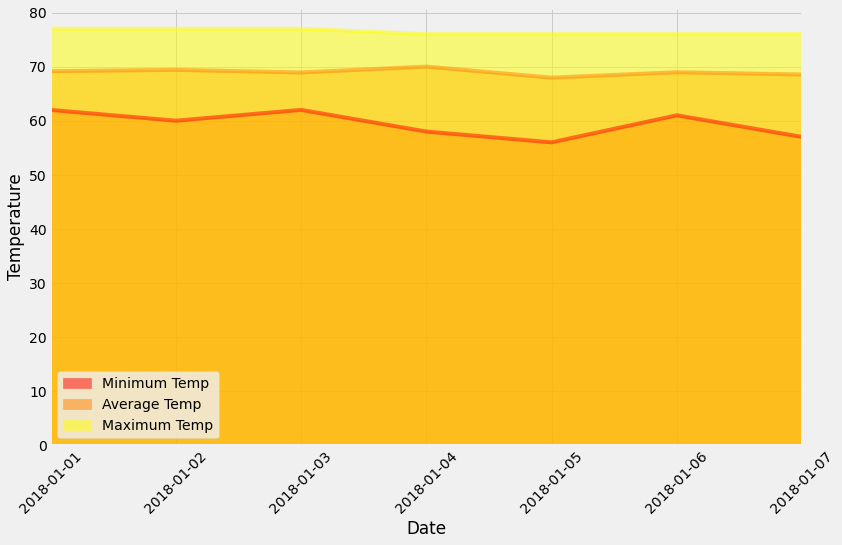

In [18]:
grouped_daily_normals_df = daily_normals_df.set_index("Date")

daily_normals_plot = grouped_daily_normals_df.plot(kind='area', stacked=False, alpha=0.5, colormap='autumn',
                                                   figsize = (12,7.5), rot=45, ylabel ="Temperature")
daily_normals_plot.xaxis.set_major_locator(mdates.DayLocator())
daily_normals_plot.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.savefig("Bonus_Outputs/Daily_Normals.png")

## Close Session